In [7]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from mpl_toolkits.mplot3d import Axes3D  

Text(0, 0.5, 'F(kx)')

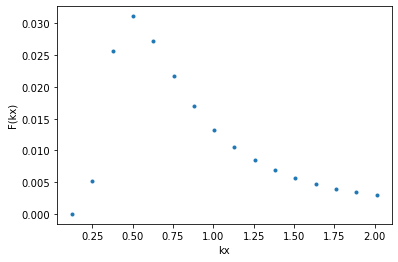

In [228]:
'''
    Initialization based on PM/Jonswap.
    All identities with _tile are two-dimensional array.
    In principle kmax = 2*np.pi/(2L/N_grid), kmin=2*np.pi/L.
    For focusing.
''' 
# Spectrum in polar coordinate
kp = 2*np.pi/10 # peak at 10m
P = 0.018

# Project onto kx,ky
N_mode = 16; L =50
kx = np.arange(1,N_mode+1,1)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
                                           
dkx = kx[1]-kx[0]; 

# F_kx = (P/kx)**2
# F_kx = P*np.ones(kx.size)
F_kx = P*kx**(-2.5)*np.exp(-0.75*(kp/kx)**2)
# interpolator = LinearNDInterpolator((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel())
# F_kxky_tile = interpolator(kx_tile, ky_tile) 
# plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
# plt.ylabel('ky'); plt.xlabel('kx')
plt.plot(kx, F_kx, '.'); plt.xlabel('kx'); plt.ylabel('F(kx)')

In [229]:
'''
    Add modes together to generate initial eta field.
    Phase not random but focusing.
    1D case
'''
# This is the only place that the random field is generated, everything else should agree;
# and we want to seed the random number
tb = 40; xb = 0;  # travelling at group velocity?
N_grid = 256
# phase_tile = np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
# x = np.linspace(-L/2,L/2+L/N_grid,N_grid+1,endpoint=False)+L/N_grid/2; y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
x = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2 # So that interpolation does not have nan
y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
x_tile, y_tile = np.meshgrid(x, y)
omega = (9.8*kx)**0.5 # frequency based on kx or kmod
phase = -kx*xb+omega*tb
eta_tile = np.zeros(x_tile.shape)
t = 0
for i1 in range(0,N_grid):
    for i2 in range(0,N_grid):
        ampl = (2*F_kx*dkx)**0.5 # Why is this different!!!!!!!
        # How to exactly represent integrate over dk_x*dk_y*eta_hat?
        # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
        #                                    phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
        a = (kx*x_tile[i1,i2])-omega*t+phase
        mode = ampl*(np.cos(a)) # uniform space in kx and ky
#         mode = 1/64*0.5*((F_kmodtheta_tile)**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
#                                    phase_tile)*(kx[1]-kx[0]) # uniform space in kx and ky
        # The factor 0.5 is added so that the following check equals, not sure why yet...
        eta_tile[i1,i2] = np.sum(mode)   

In [151]:
'''
    Check that calculation of F(kmod) is consistent by comparing integration of F(kmod) and mean square
    of the initial eta field.
'''
dx = L/N_grid
F_integrated = np.sum(F_kx)*(kx[1]-kx[0]) # Integration over kx ky is easier
print(F_integrated)
print(np.sum((eta_tile-np.average(eta_tile))**2)/(L**2)*dx*dx)# Notice the Delta x normalization
print(np.std(eta_tile)*kp)
print(np.average(eta_tile))

0.023564242475292933
0.023564242475292943
0.0964509722589644
1.0408340855860843e-17


Text(0, 0.5, 'F(kx)')

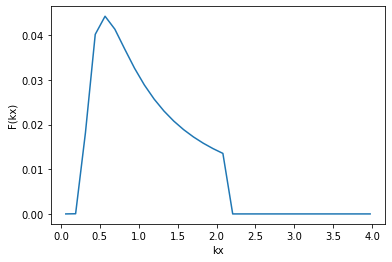

In [226]:
'''
    Check the initial spectrum.
'''
spectrum = np.fft.fft(eta_tile[127,:])*(1/256)
F = np.absolute(spectrum)
F = np.fft.fftshift(F)
dx = 50./256.
kx = np.linspace(-np.pi / dx, np.pi / dx, 256)
plt.plot(kx[128:160], F[128:160])
plt.xlabel('kx')
plt.ylabel('F(kx)')

0.21902354687214023


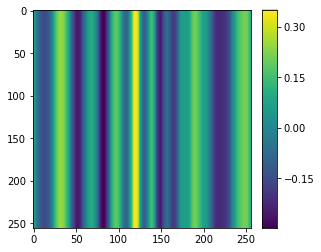

In [230]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
pcontour = grid[0].imshow(eta_tile)
# pcontour = grid[0].imshow(eta_tile_higher*kp)
grid[0].cax.colorbar(pcontour)
print(np.max(eta_tile*kp))

Text(0.5, 1.0, 'linear at t=25')

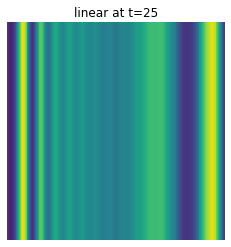

In [225]:
pcontour = plt.imshow(eta_tile, vmax=0.4, vmin=-0.4)
plt.axis('off')
# grid[0].cax.colorbar(pcontour)
# grid[0].axis('off')
plt.title('linear at t=25')

In [161]:
'''
    Output eta to file
'''
feta = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/pre/eta", 'bw')
eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

In [162]:
'''
    A second way of initializing velocity. Adding an actual z option. 
    Interpolate onto a higher level grid without introducing more higher wavenumber modes.
'''
zb = -5; z_tile = zb*np.ones(x_tile.shape) # computational domain bottom position
N_layer = 30 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
g = 9.8
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kx*dkx)**0.5
            actual_z_tile = np.minimum(ampl, np.ones(ampl.shape)*z_tile[i1,i2]) # Element wise comparison
            a = (kx*x_tile[i1,i2])+phase
            mode = ampl*(np.cos(a))
            # u = \sqrt{gk}*A*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kx)**0.5*ampl*np.exp(kx*actual_z_tile)*np.cos(a)
            v_mode = (g*kx)**0.5*ampl*np.exp(kx*actual_z_tile)*np.cos(a)*0
            w_mode = (g*kx)**0.5*ampl*np.exp(kx*actual_z_tile)*np.sin(a)
            u_tile[i1,i2] = np.sum(u_mode); v_tile[i1,i2] = np.sum(v_mode); w_tile[i1,i2] = np.sum(w_mode)
#     u_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), u_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
#     v_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), v_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
#     w_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), w_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
    u_set.append(u_tile); v_set.append(v_tile); w_set.append(w_tile); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/pre/u_layer%g" %l, "bw")
    u_output = u_tile.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/pre/v_layer%g" %l, "bw")
    v_output = v_tile.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/pre/w_layer%g" %l, "bw")
    w_output = w_tile.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

100%|██████████| 30/30 [00:59<00:00,  2.00s/it]


In [232]:
'''
    Check KE and GPE equal partition.
'''
gpe = 0.5*np.sum(eta_tile**2)*(1/N_grid)**2*9.8
print(gpe)
ke = 0
gpe_int = 0
for ilayer in range(0,N_layer):
    # Kinetic energy is integrated along the depth thus zb/N_layer
    ke += (np.sum(u_set[ilayer]**2)+np.sum(v_set[ilayer]**2)+np.sum(w_set[ilayer]**2))*(1/N_grid)**2*(0-zb)/N_layer
    gpe_int += np.sum(z_set[ilayer])*(1/N_grid)**2*(0-zb)/N_layer
ke = 0.5*ke
print(ke)
gpe_baseline = 0.5*zb**2
print((gpe_int-gpe_baseline)*9.8)

0.2610234704919623
0.2559000952425397
-245.00000000000003
